# Trading Simulation: Базов vs Подобрен Модел на 10 Тикера

Този notebook сравнява двата модела в реална търговска симулация на 10 различни тикера.

## Модели:
- **Базов модел**: `StockTransformer` (само технически features)
- **Подобрен модел**: `StockTransformerWithNews` (технически features + news embeddings)

## Метрики:
- Total Return %
- Sharpe Ratio
- Max Drawdown %
- Win Rate
- Excess Return vs Buy & Hold

In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from copy import deepcopy
from tqdm import tqdm

from src.data.loader import load_and_filter_dataset
from src.data.preprocessor import preprocess_data
from src.data.feature_engineering import create_all_features
from src.data.dataset import StockDataset, create_sequences, time_series_split
from src.data.dataset_with_news import StockDatasetWithNews, _align_news_embeddings_with_sequences
from src.data.pipeline import extract_dataset
from src.data.news_features import NewsFeatureExtractor
from src.models.transformer_model import StockTransformer
from src.models.transformer_model_with_news import StockTransformerWithNews
from src.simulation.engine import BacktestEngine
from src.simulation.metrics import compute_metrics
from src.utils.config import load_config
from src.utils import config as _cfg
from sklearn.preprocessing import StandardScaler
import yaml

config = load_config()

print("=" * 80)
print("TRADING SIMULATION: BASE vs ENHANCED MODEL")
print("=" * 80)
print(f"Training tickers: {config.data.tickers}")
print(f"Context length: {config.data.context_length}")
print("=" * 80)

TRADING SIMULATION: BASE vs ENHANCED MODEL
Training tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
Context length: 60


In [3]:
# Select 10 diverse tickers from different sectors
# These should NOT be in training set
TRAINING_TICKERS = set(config.data.tickers)

TEST_TICKERS = [
    "DIS",   # Entertainment
    "AMD",   # Tech (semiconductors)
    "JPM",   # Financials
    "JNJ",   # Healthcare
    "WMT",   # Retail
    "V",     # Financials (payments)
    "INTC",  # Tech (semiconductors)
    "CRM",   # Tech (software)
    "NFLX",  # Entertainment (streaming)
    "BAC",   # Financials (banking)
]

print(f"Training tickers: {sorted(TRAINING_TICKERS)}")
print(f"\nTesting on {len(TEST_TICKERS)} tickers:")
for i, ticker in enumerate(TEST_TICKERS, 1):
    print(f"  {i}. {ticker}")

Training tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT']

Testing on 10 tickers:
  1. DIS
  2. AMD
  3. JPM
  4. JNJ
  5. WMT
  6. V
  7. INTC
  8. CRM
  9. NFLX
  10. BAC


In [4]:
# Load simulation config
config_path = _cfg.PROJECT_ROOT / "configs" / "default_config.yaml"
with config_path.open("r", encoding="utf-8") as f:
    raw_cfg = yaml.safe_load(f)
sim = raw_cfg.get("simulation", {})

initial_capital = float(sim.get("initial_capital", 100_000))
position_size_pct = float(sim.get("position_size_pct", 0.3))
entry_threshold_pct = float(sim.get("entry_threshold_pct", 0.5))
exit_threshold_pct = float(sim.get("exit_threshold_pct", -5.0))
commission_pct = float(sim.get("commission_pct", 0.1))
risk_free_rate_annual = float(sim.get("risk_free_rate_annual", 0.03))

print(f"Simulation config:")
print(f"  Initial capital: ${initial_capital:,.0f}")
print(f"  Position size: {position_size_pct*100:.0f}%")
print(f"  Entry threshold: {entry_threshold_pct}%")
print(f"  Exit threshold: {exit_threshold_pct}%")
print(f"  Commission: {commission_pct}%")

Simulation config:
  Initial capital: $100,000
  Position size: 30%
  Entry threshold: 0.5%
  Exit threshold: -5.0%
  Commission: 0.1%


In [5]:
# Load base model
print("\n🔧 Loading BASE model...")
base_model_path = _cfg.PROJECT_ROOT / "models/checkpoints/best_model_base.pt"

if not base_model_path.exists():
    print(f"⚠️  Base model not found at {base_model_path}")
    print("  Will skip base model simulation")
    base_model = None
else:
    checkpoint = torch.load(base_model_path, map_location='cpu', weights_only=False)
    state_dict = checkpoint['model_state_dict']
    
    # Get model parameters
    d_model = state_dict["input_projection.weight"].shape[0]
    input_dim = state_dict["input_projection.weight"].shape[1]
    
    base_model = StockTransformer(
        input_dim=input_dim,
        d_model=d_model,
        n_heads=config.model.n_heads,
        n_layers=config.model.n_layers,
        d_ff=config.model.d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    base_model.load_state_dict(state_dict, strict=False)
    base_model.eval()
    print(f"✅ Base model loaded")
    print(f"  Validation loss: {checkpoint.get('score', 'N/A'):.6f}")


🔧 Loading BASE model...
✅ Base model loaded
  Validation loss: 0.017291


In [6]:
# Load enhanced model
print("\n🔧 Loading ENHANCED model...")
enhanced_model_path = _cfg.PROJECT_ROOT / "models/checkpoints/best_model_with_news.pt"

if not enhanced_model_path.exists():
    print(f"⚠️  Enhanced model not found at {enhanced_model_path}")
    print("  Will skip enhanced model simulation")
    enhanced_model = None
else:
    checkpoint = torch.load(enhanced_model_path, map_location='cpu', weights_only=False)
    state_dict = checkpoint['model_state_dict']
    
    # Get model parameters
    d_model = state_dict["input_projection.weight"].shape[0]
    input_dim = state_dict["input_projection.weight"].shape[1]
    
    # Check fusion method
    if 'output_projection.weight' in state_dict:
        output_shape = state_dict['output_projection.weight'].shape
        if output_shape[1] > d_model * 1.5:
            fusion_method = "concat"
        else:
            fusion_method = "add"
    else:
        fusion_method = "concat"
    
    enhanced_model = StockTransformerWithNews(
        input_dim=input_dim,
        news_embedding_dim=768,
        d_model=d_model,
        n_heads=config.model.n_heads,
        n_layers=config.model.n_layers,
        d_ff=config.model.d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
        news_fusion_method=fusion_method,
    )
    enhanced_model.load_state_dict(state_dict, strict=False)
    enhanced_model.eval()
    print(f"✅ Enhanced model loaded")
    print(f"  Validation loss: {checkpoint.get('score', 'N/A'):.6f}")
    print(f"  Fusion method: {fusion_method}")


🔧 Loading ENHANCED model...
✅ Enhanced model loaded
  Validation loss: 0.017069
  Fusion method: concat


In [7]:
# Load training data to fit scaler (same as model training)
print("\n📊 Loading training data for scaler...")
df_train_original, feature_columns = extract_dataset(config=config)
train_df_original, _, _ = time_series_split(
    df_train_original,
    train_split=config.data.train_split,
    val_split=config.data.val_split,
    test_split=config.data.test_split,
)

# Fit scaler on original training data
all_numeric_cols = feature_columns + ["close"]
scaler = StandardScaler()
scaler.fit(train_df_original[all_numeric_cols])
print(f"✅ Scaler fitted on {len(train_df_original)} training samples")
print(f"  Feature columns: {len(feature_columns)}")


📊 Loading training data for scaler...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet


Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
✅ Scaler fitted on 6936 training samples
  Feature columns: 34


In [8]:
# Test both models on each ticker
base_results = []
enhanced_results = []

for ticker in tqdm(TEST_TICKERS, desc="Testing tickers"):
    try:
        # Load data for this ticker
        test_config = deepcopy(config)
        test_config.data.tickers = [ticker]
        
        df_raw = load_and_filter_dataset(
            config=test_config,
            tickers=[ticker],
            start_date=test_config.data.start_date,
            end_date=test_config.data.end_date,
        )
        
        if len(df_raw) == 0:
            print(f"⚠️  No data for {ticker}, skipping...")
            continue
        
        # Preprocess
        df_processed, _ = preprocess_data(
            df_raw,
            handle_missing=True,
            missing_method="forward_fill",
            handle_outliers_flag=True,
            outliers_method="clip",
            normalize=False,
            date_column="date",
            symbol_column="symbol",
        )
        
        # Create features
        df_features = create_all_features(
            df_processed,
            price_column="close",
            high_column="high",
            low_column="low",
            volume_column="volume",
            date_column="date",
            symbol_column="symbol",
            windows=test_config.data.features.windows,
            lags=[1, 2, 3, 5, 10] if test_config.data.features.lag_features else [],
            add_technical=test_config.data.features.technical_indicators,
            add_lags=test_config.data.features.lag_features,
            add_temporal=test_config.data.features.temporal_features,
            add_volume=True,
            simplified=test_config.data.features.simplified,
        )
        
        df_features = df_features.dropna()
        
        if len(df_features) == 0:
            print(f"⚠️  No valid data after feature engineering for {ticker}, skipping...")
            continue
        
        # Apply scaler
        df_features[all_numeric_cols] = scaler.transform(df_features[all_numeric_cols])
        
        # Split into train/val/test
        train_df, val_df, test_df = time_series_split(
            df_features,
            train_split=test_config.data.train_split,
            val_split=test_config.data.val_split,
            test_split=test_config.data.test_split,
        )
        
        if len(test_df) < config.data.context_length + 10:
            print(f"⚠️  Not enough test data for {ticker}, skipping...")
            continue
        
        # Create dataset
        test_data = test_df[feature_columns].values
        test_targets = test_df["close"].values.reshape(-1, 1)
        
        test_X, test_y = create_sequences(
            np.column_stack([test_data, test_targets]),
            config.data.context_length,
            config.data.prediction_horizon,
        )
        
        test_X = test_X[:, :, :-1]
        if config.data.prediction_horizon > 1:
            test_y = test_y[:, :, -1]
        else:
            test_y = test_y[:, -1, -1]
            if test_y.ndim == 0:
                test_y = test_y.reshape(-1, 1)
        
        test_dataset = StockDataset(test_X, test_y, config.data.context_length, config.data.prediction_horizon)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        # Align prices for backtest
        test_prices = test_df["close"].values
        context_length = config.data.context_length
        prices_for_backtest = test_prices[context_length:]
        
        # Test BASE model
        if base_model is not None:
            base_predictions = []
            with torch.no_grad():
                for batch in test_loader:
                    features, _ = batch
                    preds = base_model(features)
                    base_predictions.append(preds.cpu().numpy())
            
            base_pred_next = np.concatenate(base_predictions).ravel()
            min_len = min(len(base_pred_next), len(prices_for_backtest))
            base_prices = prices_for_backtest[:min_len]
            base_pred = base_pred_next[:min_len]
            
            # Run backtest
            engine = BacktestEngine(
                initial_capital=initial_capital,
                position_size_pct=position_size_pct,
                entry_threshold_pct=entry_threshold_pct,
                exit_threshold_pct=exit_threshold_pct,
                commission_pct=commission_pct,
            )
            
            result = engine.run(prices=base_prices, predictions=base_pred)
            metrics = compute_metrics(
                result,
                initial_capital=initial_capital,
                risk_free_rate_annual=risk_free_rate_annual,
                prices=base_prices,
            )
            
            base_results.append({
                "ticker": ticker,
                "equity_curve": result.equity_curve,
                "prices": base_prices,
                "total_return_pct": metrics.total_return_pct,
                "sharpe_ratio": metrics.sharpe_ratio_annual,
                "max_drawdown_pct": metrics.max_drawdown_pct,
                "num_trades": metrics.num_trades,
                "buy_hold_return_pct": metrics.buy_and_hold_return_pct,
                "excess_return_pct": metrics.excess_return_vs_bh_pct,
                "final_equity": result.equity_curve[-1],
            })
        
        # Test ENHANCED model with news embeddings
        if enhanced_model is not None:
            # Extract news embeddings for this ticker
            tqdm.write(f"  📰 Extracting news for {ticker}...")
            news_extractor = NewsFeatureExtractor()
            news_embeddings_df = news_extractor.get_news_for_dataframe(
                test_df,
                date_column="date",
                symbol_column="symbol",
                use_cache=True,
            )
            
            # Align news embeddings with sequences
            test_news_embeddings = None
            if news_embeddings_df is not None and len(news_embeddings_df) > 0:
                test_news_embeddings = _align_news_embeddings_with_sequences(
                    test_df,
                    test_X,
                    news_embeddings_df,
                    date_column="date",
                    symbol_column="symbol",
                    context_length=config.data.context_length,
                )
                if test_news_embeddings is not None:
                    # Check if we have non-zero embeddings
                    non_zero_count = np.count_nonzero(np.any(test_news_embeddings != 0, axis=1))
                    tqdm.write(f"    ✅ {len(test_news_embeddings)} news embeddings ({non_zero_count} non-zero)")
                else:
                    tqdm.write(f"    ⚠️  Failed to align news embeddings")
            else:
                tqdm.write(f"    ⚠️  No news embeddings found")
            
            # Create dataset with news
            test_dataset_enhanced = StockDatasetWithNews(
                test_X, test_y, test_news_embeddings,
                config.data.context_length, config.data.prediction_horizon
            )
            test_loader_enhanced = DataLoader(test_dataset_enhanced, batch_size=64, shuffle=False)
            
            enhanced_predictions = []
            with torch.no_grad():
                for batch in test_loader_enhanced:
                    features, news_emb, _ = batch
                    # Pass news embeddings to enhanced model
                    preds = enhanced_model(features, news_embeddings=news_emb)
                    enhanced_predictions.append(preds.cpu().numpy())
            
            enhanced_pred_next = np.concatenate(enhanced_predictions).ravel()
            min_len = min(len(enhanced_pred_next), len(prices_for_backtest))
            enhanced_prices = prices_for_backtest[:min_len]
            enhanced_pred = enhanced_pred_next[:min_len]
            
            # Run backtest
            engine = BacktestEngine(
                initial_capital=initial_capital,
                position_size_pct=position_size_pct,
                entry_threshold_pct=entry_threshold_pct,
                exit_threshold_pct=exit_threshold_pct,
                commission_pct=commission_pct,
            )
            
            result = engine.run(prices=enhanced_prices, predictions=enhanced_pred)
            metrics = compute_metrics(
                result,
                initial_capital=initial_capital,
                risk_free_rate_annual=risk_free_rate_annual,
                prices=enhanced_prices,
            )
            
            enhanced_results.append({
                "ticker": ticker,
                "equity_curve": result.equity_curve,
                "prices": enhanced_prices,
                "total_return_pct": metrics.total_return_pct,
                "sharpe_ratio": metrics.sharpe_ratio_annual,
                "max_drawdown_pct": metrics.max_drawdown_pct,
                "num_trades": metrics.num_trades,
                "buy_hold_return_pct": metrics.buy_and_hold_return_pct,
                "excess_return_pct": metrics.excess_return_vs_bh_pct,
                "final_equity": result.equity_curve[-1],
            })
        
    except Exception as e:
        print(f"❌ Error processing {ticker}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n✅ Successfully tested:")
print(f"  Base model: {len(base_results)} tickers")
print(f"  Enhanced model: {len(enhanced_results)} tickers")

Testing tickers:   0%|          | 0/10 [00:00<?, ?it/s]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:   0%|          | 0/10 [00:01<?, ?it/s]

  📰 Extracting news for DIS...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for DIS from 2019-04-08 to 2020-09-30...
⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 2 days of news with FinBERT...


Testing tickers:   0%|          | 0/10 [00:05<?, ?it/s]

💾 Caching news embeddings to data\processed\news_cache\DIS_20190408_20200930.pkl
    ✅ 315 news embeddings (0 non-zero)


Testing tickers:  10%|█         | 1/10 [00:05<00:49,  5.51s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  10%|█         | 1/10 [00:06<00:49,  5.51s/it]

  📰 Extracting news for AMD...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for AMD from 2019-04-02 to 2020-09-30...


Testing tickers:  10%|█         | 1/10 [00:09<00:49,  5.51s/it]

⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 2 days of news with FinBERT...
💾 Caching news embeddings to data\processed\news_cache\AMD_20190402_20200930.pkl
    ✅ 315 news embeddings (0 non-zero)


Testing tickers:  20%|██        | 2/10 [00:09<00:37,  4.69s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  20%|██        | 2/10 [00:11<00:37,  4.69s/it]

  📰 Extracting news for JPM...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for JPM from 2019-04-05 to 2020-09-30...
⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 1 days of news with FinBERT...
💾 Caching news embeddings to data\processed\news_cache\JPM_20190405_20200930.pkl


Testing tickers:  20%|██        | 2/10 [00:13<00:37,  4.69s/it]

    ✅ 316 news embeddings (0 non-zero)


Testing tickers:  30%|███       | 3/10 [00:13<00:30,  4.36s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  30%|███       | 3/10 [00:14<00:30,  4.36s/it]

  📰 Extracting news for JNJ...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for JNJ from 2019-04-05 to 2020-09-30...


Testing tickers:  30%|███       | 3/10 [00:17<00:30,  4.36s/it]

⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 1 days of news with FinBERT...
💾 Caching news embeddings to data\processed\news_cache\JNJ_20190405_20200930.pkl
    ✅ 316 news embeddings (0 non-zero)


Testing tickers:  40%|████      | 4/10 [00:17<00:24,  4.12s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)


Testing tickers:  50%|█████     | 5/10 [00:18<00:14,  2.99s/it]

Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (0, 25)
⚠️  No data for WMT, skipping...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)


Testing tickers:  60%|██████    | 6/10 [00:19<00:09,  2.34s/it]

Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (0, 25)
⚠️  No data for V, skipping...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  60%|██████    | 6/10 [00:20<00:09,  2.34s/it]

  📰 Extracting news for INTC...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for INTC from 2019-04-01 to 2020-09-30...


Testing tickers:  60%|██████    | 6/10 [00:22<00:09,  2.34s/it]

⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 1 days of news with FinBERT...
💾 Caching news embeddings to data\processed\news_cache\INTC_20190401_20200930.pkl
    ✅ 314 news embeddings (0 non-zero)


Testing tickers:  70%|███████   | 7/10 [00:23<00:08,  2.81s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2578, 25)


Testing tickers:  70%|███████   | 7/10 [00:24<00:08,  2.81s/it]

  📰 Extracting news for CRM...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for CRM from 2019-03-13 to 2020-09-14...
⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 2 days of news with FinBERT...
💾 Caching news embeddings to data\processed\news_cache\CRM_20190313_20200914.pkl


Testing tickers:  70%|███████   | 7/10 [00:26<00:08,  2.81s/it]

    ✅ 321 news embeddings (0 non-zero)


Testing tickers:  80%|████████  | 8/10 [00:27<00:06,  3.17s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  80%|████████  | 8/10 [00:28<00:06,  3.17s/it]

  📰 Extracting news for NFLX...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for NFLX from 2019-04-05 to 2020-09-30...


Testing tickers:  80%|████████  | 8/10 [00:31<00:06,  3.17s/it]

⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 1 days of news with FinBERT...
💾 Caching news embeddings to data\processed\news_cache\NFLX_20190405_20200930.pkl
    ✅ 316 news embeddings (0 non-zero)


Testing tickers:  90%|█████████ | 9/10 [00:31<00:03,  3.53s/it]

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (2517, 25)


Testing tickers:  90%|█████████ | 9/10 [00:32<00:03,  3.53s/it]

  📰 Extracting news for BAC...
Loading FinBERT encoder...
Loading FinBERT model: ProsusAI/finbert
Device: cpu
✅ FinBERT loaded successfully
📰 Fetching news for BAC from 2019-04-08 to 2020-09-30...


Testing tickers:  90%|█████████ | 9/10 [00:34<00:03,  3.53s/it]

⚠️  Free tier limitation: Only 2 articles per request. Requested 100.
🔢 Encoding 2 days of news with FinBERT...
💾 Caching news embeddings to data\processed\news_cache\BAC_20190408_20200930.pkl
    ✅ 315 news embeddings (0 non-zero)


Testing tickers: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


✅ Successfully tested:
  Base model: 8 tickers
  Enhanced model: 8 tickers


In [9]:
# Create comparison summary
print("\n" + "=" * 80)
print("TRADING RESULTS COMPARISON")
print("=" * 80)

if base_results and enhanced_results:
    # Create DataFrames
    df_base = pd.DataFrame(base_results)
    df_enhanced = pd.DataFrame(enhanced_results)
    
    # Merge on ticker for comparison
    df_comparison = df_base.merge(
        df_enhanced,
        on='ticker',
        suffixes=('_base', '_enhanced')
    )
    
    print(f"\n{'Ticker':<8} {'Base Return':<15} {'Enhanced Return':<18} {'Difference':<15} {'Base Sharpe':<15} {'Enhanced Sharpe':<18}")
    print("-" * 100)
    
    for _, row in df_comparison.iterrows():
        diff = row['total_return_pct_enhanced'] - row['total_return_pct_base']
        print(f"{row['ticker']:<8} {row['total_return_pct_base']:>13.2f}% {row['total_return_pct_enhanced']:>16.2f}% {diff:>13.2f}% {row['sharpe_ratio_base']:>13.3f} {row['sharpe_ratio_enhanced']:>16.3f}")
    
    print("-" * 100)
    print(f"{'AVERAGE':<8} {df_base['total_return_pct'].mean():>13.2f}% {df_enhanced['total_return_pct'].mean():>16.2f}% {(df_enhanced['total_return_pct'].mean() - df_base['total_return_pct'].mean()):>13.2f}% {df_base['sharpe_ratio'].mean():>13.3f} {df_enhanced['sharpe_ratio'].mean():>16.3f}")
    
    # Win rates
    base_wins = (df_base['total_return_pct'] > 0).sum()
    enhanced_wins = (df_enhanced['total_return_pct'] > 0).sum()
    print(f"\nWin Rate:")
    print(f"  Base: {base_wins}/{len(df_base)} ({100*base_wins/len(df_base):.1f}%)")
    print(f"  Enhanced: {enhanced_wins}/{len(df_enhanced)} ({100*enhanced_wins/len(df_enhanced):.1f}%)")
    
    # Beat buy & hold
    base_beat_bh = (df_base['excess_return_pct'] > 0).sum()
    enhanced_beat_bh = (df_enhanced['excess_return_pct'] > 0).sum()
    print(f"\nBeat Buy & Hold:")
    print(f"  Base: {base_beat_bh}/{len(df_base)} ({100*base_beat_bh/len(df_base):.1f}%)")
    print(f"  Enhanced: {enhanced_beat_bh}/{len(df_enhanced)} ({100*enhanced_beat_bh/len(df_enhanced):.1f}%)")
    
elif base_results:
    df_base = pd.DataFrame(base_results)
    print(f"\n{'Ticker':<8} {'Return %':<12} {'Sharpe':<10} {'Max DD %':<12} {'Trades':<8}")
    print("-" * 60)
    for _, row in df_base.iterrows():
        print(f"{row['ticker']:<8} {row['total_return_pct']:>10.2f}% {row['sharpe_ratio']:>8.3f} {row['max_drawdown_pct']:>10.2f}% {row['num_trades']:>6}")
    print("-" * 60)
    print(f"{'AVERAGE':<8} {df_base['total_return_pct'].mean():>10.2f}% {df_base['sharpe_ratio'].mean():>8.3f} {df_base['max_drawdown_pct'].mean():>10.2f}% {df_base['num_trades'].mean():>6.0f}")
    
elif enhanced_results:
    df_enhanced = pd.DataFrame(enhanced_results)
    print(f"\n{'Ticker':<8} {'Return %':<12} {'Sharpe':<10} {'Max DD %':<12} {'Trades':<8}")
    print("-" * 60)
    for _, row in df_enhanced.iterrows():
        print(f"{row['ticker']:<8} {row['total_return_pct']:>10.2f}% {row['sharpe_ratio']:>8.3f} {row['max_drawdown_pct']:>10.2f}% {row['num_trades']:>6}")
    print("-" * 60)
    print(f"{'AVERAGE':<8} {df_enhanced['total_return_pct'].mean():>10.2f}% {df_enhanced['sharpe_ratio'].mean():>8.3f} {df_enhanced['max_drawdown_pct'].mean():>10.2f}% {df_enhanced['num_trades'].mean():>6.0f}")
else:
    print("⚠️  No results available")


TRADING RESULTS COMPARISON

Ticker   Base Return     Enhanced Return    Difference      Base Sharpe     Enhanced Sharpe   
----------------------------------------------------------------------------------------------------
DIS               3.62%             3.62%          0.00%         0.036            0.036
AMD             -48.92%           -48.92%          0.00%        -1.393           -1.393
JPM               3.52%             3.52%          0.00%         0.047            0.047
JNJ              -3.04%            -3.04%          0.00%        -0.637           -0.637
INTC             -3.23%            -3.23%          0.00%        -0.262           -0.262
CRM              -9.28%            -9.28%          0.00%        -0.861           -0.861
NFLX             -9.62%            -9.62%          0.00%        -0.902           -0.902
BAC               4.27%             4.27%          0.00%         0.096            0.096
-----------------------------------------------------------------------


✅ Comparison plots saved to results/plots/trading_comparison_10_tickers.png


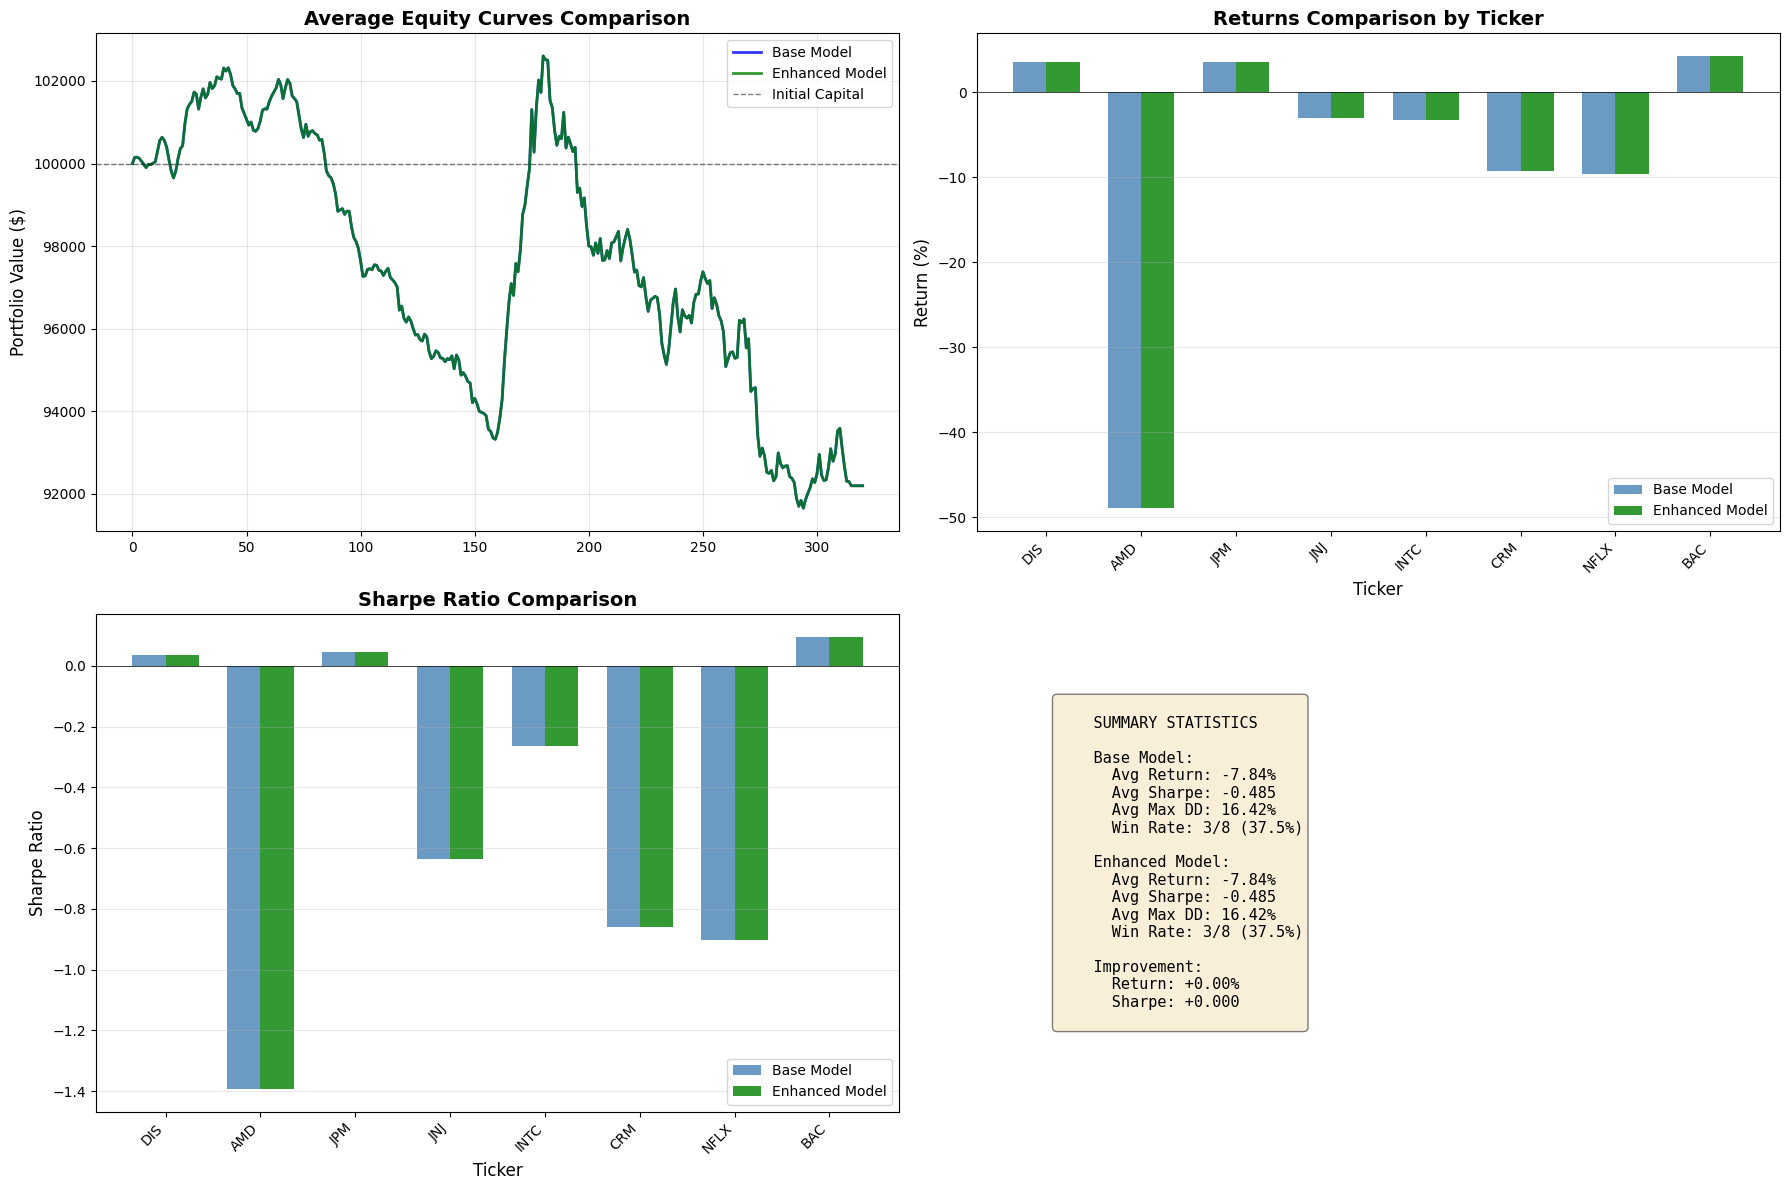

In [10]:
# Visualize comparison
if base_results and enhanced_results:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot 1: Equity curves comparison (average)
    # Note: Different tickers may have different lengths, so we need to handle that
    ax1 = axes[0, 0]
    
    # Normalize and interpolate to common length for averaging
    max_len = max([len(r['equity_curve']) for r in base_results + enhanced_results])
    
    base_normalized = []
    for r in base_results:
        equity = r['equity_curve'] / r['equity_curve'][0] * initial_capital
        # Interpolate to max_len if needed
        if len(equity) < max_len:
            indices = np.linspace(0, len(equity) - 1, max_len)
            equity = np.interp(np.arange(max_len), np.arange(len(equity)), equity)
        base_normalized.append(equity)
    
    enhanced_normalized = []
    for r in enhanced_results:
        equity = r['equity_curve'] / r['equity_curve'][0] * initial_capital
        # Interpolate to max_len if needed
        if len(equity) < max_len:
            indices = np.linspace(0, len(equity) - 1, max_len)
            equity = np.interp(np.arange(max_len), np.arange(len(equity)), equity)
        enhanced_normalized.append(equity)
    
    base_avg_equity = np.mean(base_normalized, axis=0)
    enhanced_avg_equity = np.mean(enhanced_normalized, axis=0)
    
    ax1.plot(base_avg_equity, label='Base Model', linewidth=2, alpha=0.8, color='blue')
    ax1.plot(enhanced_avg_equity, label='Enhanced Model', linewidth=2, alpha=0.8, color='green')
    ax1.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.set_title('Average Equity Curves Comparison', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Returns comparison
    ax2 = axes[0, 1]
    df_comparison = pd.DataFrame(base_results).merge(
        pd.DataFrame(enhanced_results),
        on='ticker',
        suffixes=('_base', '_enhanced')
    )
    tickers = df_comparison['ticker'].values
    x = np.arange(len(tickers))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, df_comparison['total_return_pct_base'], width, 
                    label='Base Model', color='steelblue', alpha=0.8)
    bars2 = ax2.bar(x + width/2, df_comparison['total_return_pct_enhanced'], width, 
                    label='Enhanced Model', color='green', alpha=0.8)
    
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Ticker', fontsize=12)
    ax2.set_ylabel('Return (%)', fontsize=12)
    ax2.set_title('Returns Comparison by Ticker', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(tickers, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Sharpe Ratio comparison
    ax3 = axes[1, 0]
    bars1 = ax3.bar(x - width/2, df_comparison['sharpe_ratio_base'], width, 
                    label='Base Model', color='steelblue', alpha=0.8)
    bars2 = ax3.bar(x + width/2, df_comparison['sharpe_ratio_enhanced'], width, 
                    label='Enhanced Model', color='green', alpha=0.8)
    
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_xlabel('Ticker', fontsize=12)
    ax3.set_ylabel('Sharpe Ratio', fontsize=12)
    ax3.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(tickers, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Win rate and metrics summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"""
    SUMMARY STATISTICS
    
    Base Model:
      Avg Return: {df_base['total_return_pct'].mean():.2f}%
      Avg Sharpe: {df_base['sharpe_ratio'].mean():.3f}
      Avg Max DD: {df_base['max_drawdown_pct'].mean():.2f}%
      Win Rate: {(df_base['total_return_pct'] > 0).sum()}/{len(df_base)} ({(df_base['total_return_pct'] > 0).sum()/len(df_base)*100:.1f}%)
    
    Enhanced Model:
      Avg Return: {df_enhanced['total_return_pct'].mean():.2f}%
      Avg Sharpe: {df_enhanced['sharpe_ratio'].mean():.3f}
      Avg Max DD: {df_enhanced['max_drawdown_pct'].mean():.2f}%
      Win Rate: {(df_enhanced['total_return_pct'] > 0).sum()}/{len(df_enhanced)} ({(df_enhanced['total_return_pct'] > 0).sum()/len(df_enhanced)*100:.1f}%)
    
    Improvement:
      Return: {df_enhanced['total_return_pct'].mean() - df_base['total_return_pct'].mean():+.2f}%
      Sharpe: {df_enhanced['sharpe_ratio'].mean() - df_base['sharpe_ratio'].mean():+.3f}
    """
    ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('results/plots/trading_comparison_10_tickers.png', dpi=150, bbox_inches='tight')
    print("\n✅ Comparison plots saved to results/plots/trading_comparison_10_tickers.png")
    plt.show()
    
elif base_results:
    # Only base model available
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    df_base = pd.DataFrame(base_results)
    
    # Equity curves
    ax1 = axes[0]
    for result in base_results:
        equity = result['equity_curve'] / result['equity_curve'][0] * initial_capital
        ax1.plot(equity, label=result['ticker'], alpha=0.7, linewidth=1.5)
    ax1.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.set_title('Base Model: Equity Curves')
    ax1.legend(ncol=2, fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Returns
    ax2 = axes[1]
    ax2.bar(df_base['ticker'], df_base['total_return_pct'], color='steelblue', alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_ylabel('Return (%)')
    ax2.set_title('Base Model: Returns by Ticker')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
elif enhanced_results:
    # Only enhanced model available
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    df_enhanced = pd.DataFrame(enhanced_results)
    
    # Equity curves
    ax1 = axes[0]
    for result in enhanced_results:
        equity = result['equity_curve'] / result['equity_curve'][0] * initial_capital
        ax1.plot(equity, label=result['ticker'], alpha=0.7, linewidth=1.5)
    ax1.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.set_title('Enhanced Model: Equity Curves')
    ax1.legend(ncol=2, fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Returns
    ax2 = axes[1]
    ax2.bar(df_enhanced['ticker'], df_enhanced['total_return_pct'], color='green', alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_ylabel('Return (%)')
    ax2.set_title('Enhanced Model: Returns by Ticker')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No results to visualize")


✅ Detailed ticker plots saved to results/plots/trading_all_tickers_detailed.png


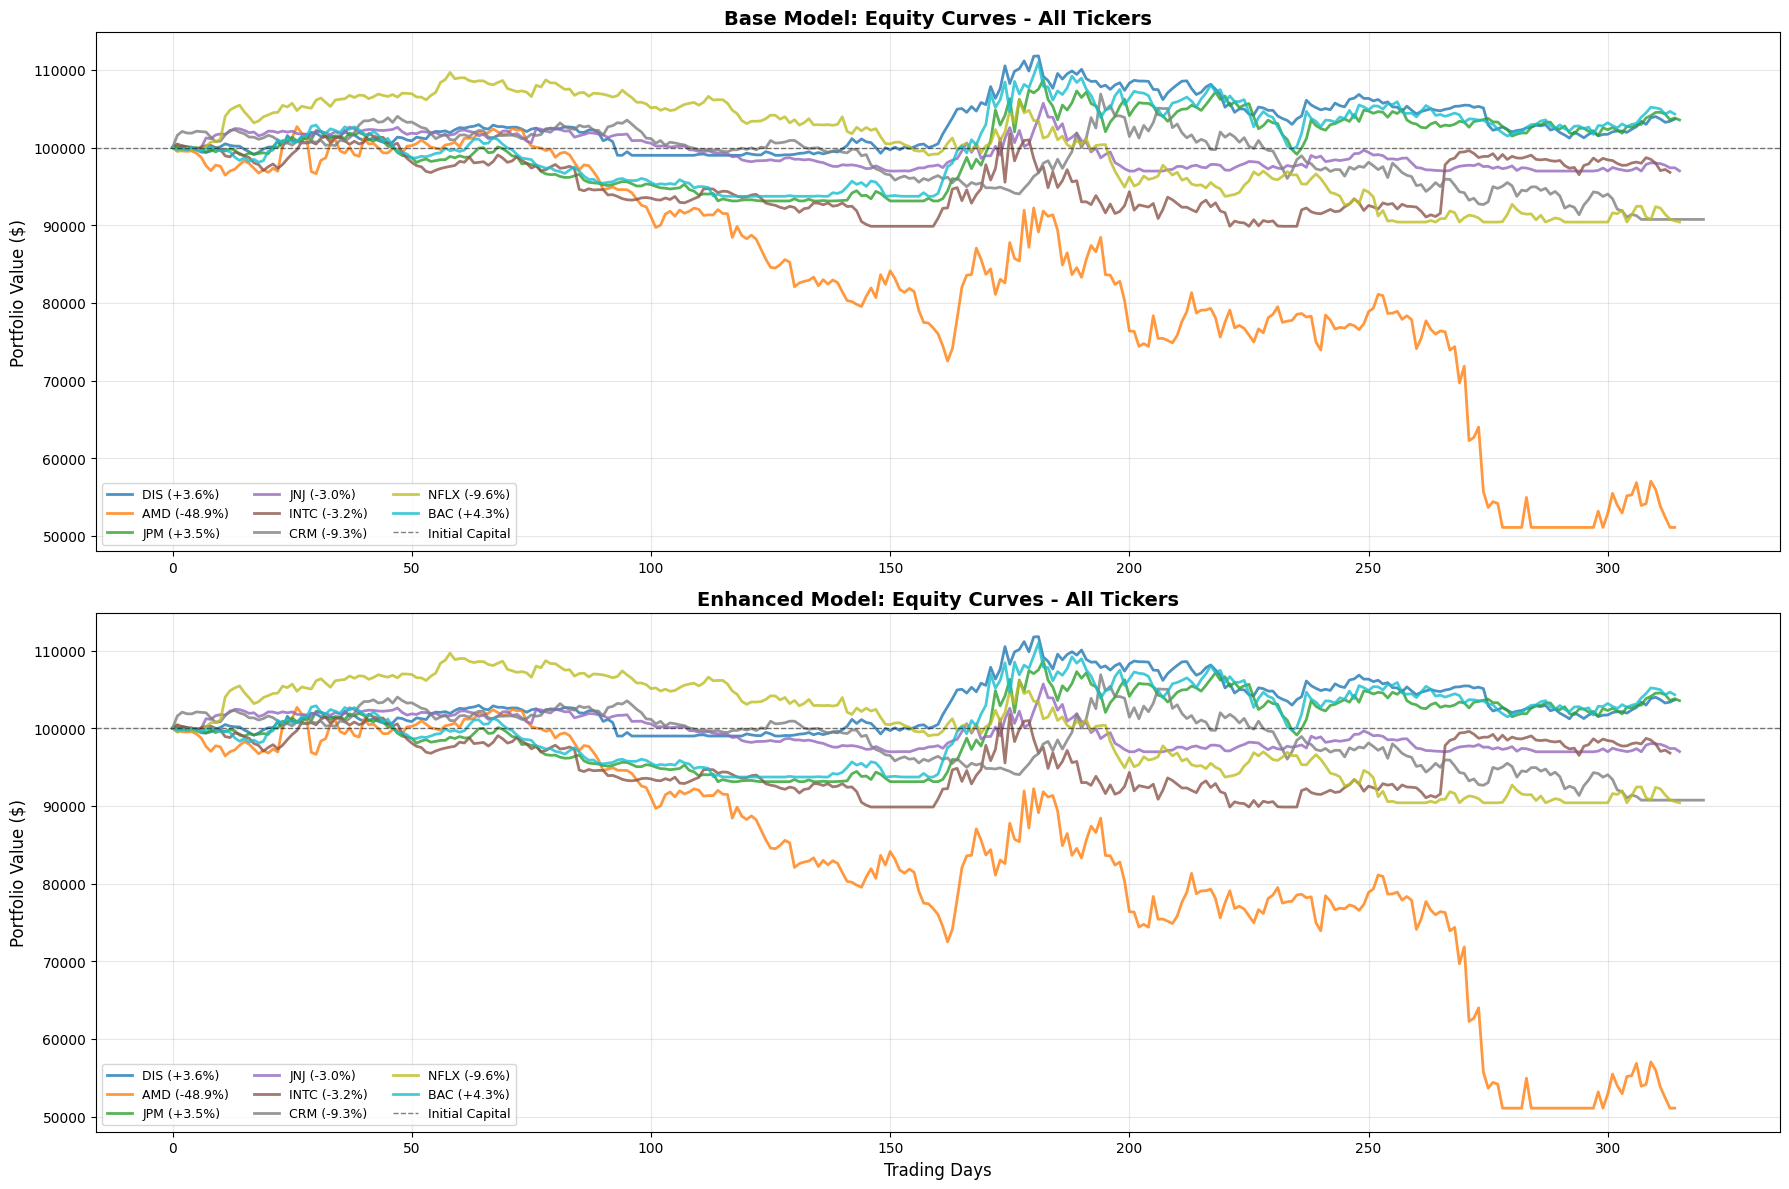

In [11]:
# Detailed visualization: All tickers equity curves
if base_results and enhanced_results:
    fig, axes = plt.subplots(2, 1, figsize=(18, 12))
    
    # Plot 1: Base Model - All tickers
    ax1 = axes[0]
    colors = plt.cm.tab10(np.linspace(0, 1, len(base_results)))
    
    for i, result in enumerate(base_results):
        ticker = result['ticker']
        equity = result['equity_curve'] / result['equity_curve'][0] * initial_capital
        return_pct = result['total_return_pct']
        
        ax1.plot(equity, label=f"{ticker} ({return_pct:+.1f}%)", 
                color=colors[i], linewidth=2, alpha=0.8)
    
    ax1.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.set_title('Base Model: Equity Curves - All Tickers', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', ncol=3, fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Enhanced Model - All tickers
    ax2 = axes[1]
    
    for i, result in enumerate(enhanced_results):
        ticker = result['ticker']
        equity = result['equity_curve'] / result['equity_curve'][0] * initial_capital
        return_pct = result['total_return_pct']
        
        ax2.plot(equity, label=f"{ticker} ({return_pct:+.1f}%)", 
                color=colors[i], linewidth=2, alpha=0.8)
    
    ax2.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
    ax2.set_xlabel('Trading Days', fontsize=12)
    ax2.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax2.set_title('Enhanced Model: Equity Curves - All Tickers', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', ncol=3, fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/plots/trading_all_tickers_detailed.png', dpi=150, bbox_inches='tight')
    print("\n✅ Detailed ticker plots saved to results/plots/trading_all_tickers_detailed.png")
    plt.show()
    
elif base_results:
    # Only base model
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(base_results)))
    
    for i, result in enumerate(base_results):
        ticker = result['ticker']
        equity = result['equity_curve'] / result['equity_curve'][0] * initial_capital
        return_pct = result['total_return_pct']
        
        ax.plot(equity, label=f"{ticker} ({return_pct:+.1f}%)", 
               color=colors[i], linewidth=2, alpha=0.8)
    
    ax.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
    ax.set_xlabel('Trading Days', fontsize=12)
    ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.set_title('Base Model: Equity Curves - All Tickers', fontsize=14, fontweight='bold')
    ax.legend(loc='best', ncol=3, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/plots/trading_all_tickers_base.png', dpi=150, bbox_inches='tight')
    print("\n✅ Detailed ticker plots saved to results/plots/trading_all_tickers_base.png")
    plt.show()
    
elif enhanced_results:
    # Only enhanced model
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(enhanced_results)))
    
    for i, result in enumerate(enhanced_results):
        ticker = result['ticker']
        equity = result['equity_curve'] / result['equity_curve'][0] * initial_capital
        return_pct = result['total_return_pct']
        
        ax.plot(equity, label=f"{ticker} ({return_pct:+.1f}%)", 
               color=colors[i], linewidth=2, alpha=0.8)
    
    ax.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')
    ax.set_xlabel('Trading Days', fontsize=12)
    ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.set_title('Enhanced Model: Equity Curves - All Tickers', fontsize=14, fontweight='bold')
    ax.legend(loc='best', ncol=3, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/plots/trading_all_tickers_enhanced.png', dpi=150, bbox_inches='tight')
    print("\n✅ Detailed ticker plots saved to results/plots/trading_all_tickers_enhanced.png")
    plt.show()
else:
    print("⚠️  No results to visualize")


✅ Side-by-side comparison saved to results/plots/trading_comparison_by_ticker.png


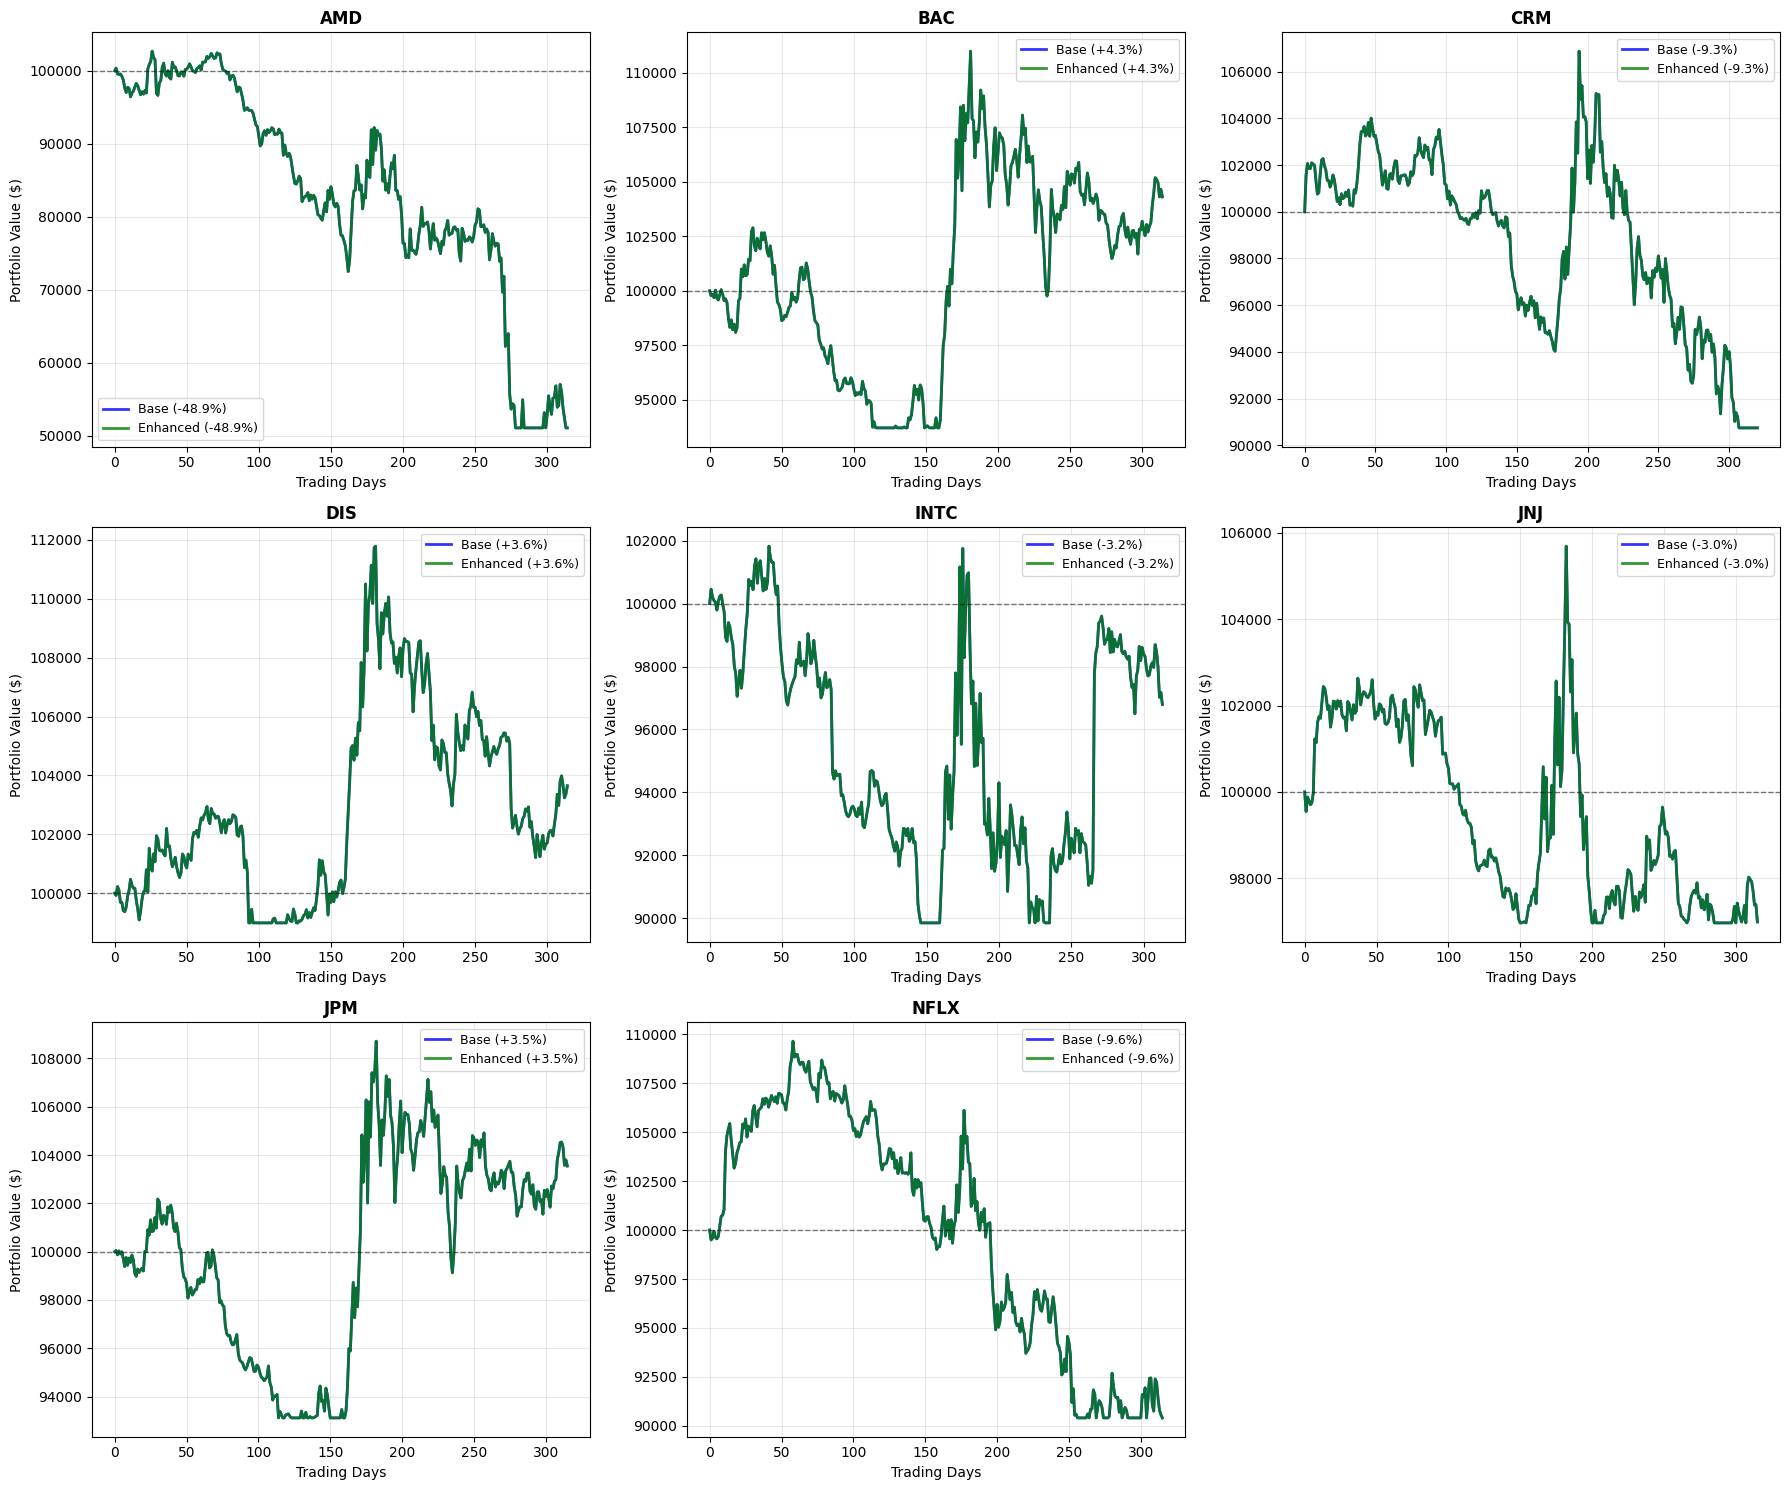

In [12]:
# Side-by-side comparison: Base vs Enhanced for each ticker
if base_results and enhanced_results:
    # Match tickers between base and enhanced results
    base_dict = {r['ticker']: r for r in base_results}
    enhanced_dict = {r['ticker']: r for r in enhanced_results}
    common_tickers = sorted(set(base_dict.keys()) & set(enhanced_dict.keys()))
    
    if common_tickers:
        n_tickers = len(common_tickers)
        n_cols = 3
        n_rows = (n_tickers + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        for idx, ticker in enumerate(common_tickers):
            ax = axes[idx]
            
            base_result = base_dict[ticker]
            enhanced_result = enhanced_dict[ticker]
            
            base_equity = base_result['equity_curve'] / base_result['equity_curve'][0] * initial_capital
            enhanced_equity = enhanced_result['equity_curve'] / enhanced_result['equity_curve'][0] * initial_capital
            
            base_return = base_result['total_return_pct']
            enhanced_return = enhanced_result['total_return_pct']
            
            ax.plot(base_equity, label=f"Base ({base_return:+.1f}%)", 
                   color='blue', linewidth=2, alpha=0.8)
            ax.plot(enhanced_equity, label=f"Enhanced ({enhanced_return:+.1f}%)", 
                   color='green', linewidth=2, alpha=0.8)
            ax.axhline(y=initial_capital, color='black', linestyle='--', linewidth=1, alpha=0.5)
            
            ax.set_title(f'{ticker}', fontsize=12, fontweight='bold')
            ax.set_xlabel('Trading Days', fontsize=10)
            ax.set_ylabel('Portfolio Value ($)', fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(common_tickers), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('results/plots/trading_comparison_by_ticker.png', dpi=150, bbox_inches='tight')
        print("\n✅ Side-by-side comparison saved to results/plots/trading_comparison_by_ticker.png")
        plt.show()
    else:
        print("⚠️  No common tickers between base and enhanced results")
else:
    print("⚠️  Need both models for side-by-side comparison")